In [ ]:
import os

import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import build_odeint, odeint
import jax.numpy as np
from jax.random import PRNGKey
import numpy as onp

import numpyro
import numpyro.distributions as dist
# from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
numpyro.enable_x64()

# Data

In [ ]:
import pandas as pd

ix = pd.IndexSlice

full = pd.read_csv('full.csv', index_col=['location', 'date', 'variable'], parse_dates=['date']).iloc[:, 0]
populations_country = pd.read_csv('populations_country.csv', index_col='location').iloc[:, 0]

subset = full.loc['France']
deaths_subset = subset.loc[ix[:, 'total_deaths']]

pop_fr = populations_country.loc['France']

ten_deaths_date = deaths_subset.gt(10).cumsum().loc[lambda s: s==1].index[0]
begin_date = ten_deaths_date - pd.Timedelta(30, unit='days')

total_deaths = deaths_subset.loc[begin_date:].values
data = total_deaths / pop_fr

times = deaths_subset.loc[begin_date:].index.map(onp.datetime64).to_numpy()

# SEIR-HCD


Parameters used in the model

R_t = reproduction number at time t. Typical 3.6* at t=0

Transition times

    T_inc = average incubation period. Typical 5.6* days
    T_inf = average infectious period. Typical 2.9 days
    T_hosp = average time a patient is in hospital before either recovering or becoming critical. Typical 4 days
    T_crit = average time a patient is in a critical state (either recover or die). Typical 14 days

Fractions  
These constants are likely to be age specific (hence the subscript a):

    m_a = fraction of infections that are asymptomatic or mild. Assumed 80% (i.e. 20% severe)
    c_a = fraction of severe cases that turn critical. Assumed 10%
    f_a = fraction of critical cases that are fatal. Assumed 30%
    
*Averages taken from https://www.kaggle.com/covid-19-contributions

In [3]:
def dz_dt(z, t, r0, r1, t_lim, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
#     s = np.clip(z[0], 0., 1.)
#     e = np.clip(z[1], 0., 1.)
#     i = np.clip(z[2], 0., 1.)
#     r = np.clip(z[3], 0., 1.)
#     h = np.clip(z[4], 0., 1.)
#     c = np.clip(z[5], 0., 1.)
#     d = np.clip(z[6], 0., 1.)
    s = z[0]
    e = z[1]
    i = z[2]
    r = z[3]
    h = z[4]
    c = z[5]
#     d = z[6]
    
    # equivalent to rt = r0 if t < t_lim else r1
    bl = t < t_lim
    rt = r0 * bl + (1 - bl) * r1
    
    ds = - (rt / t_inf) * i * s
    de = (rt / t_inf) * i * s - (e / t_inc)
    di = e / t_inc - i / t_inf
    dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
    dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
    dc = c_a * h / t_hosp - c / t_crit
    dd = f_a * c / t_crit
    
    return np.stack([ds, de, di, dr, dh, dc, dd])

seirhcd_int = build_odeint(dz_dt, rtol=1e-5, atol=1e-9, mxstep=500)

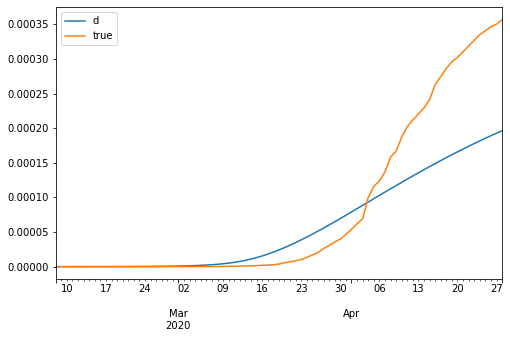

In [4]:
n_inf = 1000 / pop_fr
z_init = np.array([1. - n_inf, 0., n_inf, 0., 0., 0., 0.])
ts = np.arange(float(data.shape[0]))

# original parameters
R_0 = 3.3
R_1 = 0.8
t_lim = 30.
t_inc = 5.6
t_inf = 2.9
t_hosp = 4.
t_crit = 14.
m_a = 0.8
c_a = 0.1
f_a = 0.35

# # inferred parameters
# R_0 = 3.98
# R_1 = 0.62
# t_lim = 28.5
# t_inc = 3.77
# t_inf = 5.42
# t_hosp = 3.94
# t_crit = 22.85
# m_a = 0.77
# c_a = 0.2
# f_a = 0.44

args = (R_0, R_1, t_lim, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

res = seirhcd_int(z_init, ts, *args)
df_res = pd.DataFrame(res)
df_res.columns = 's e i r h c d'.split()

fig, ax = plt.subplots()
df_res.set_index(times)['d'].plot(figsize=(8, 5), ax=ax) ;
pd.DataFrame({'true': data}).set_index(times).plot(ax=ax)
plt.legend() ;

In [5]:
theta_esp = np.array([R_0, R_1, t_lim, t_inc, t_inf, t_hosp, t_crit])
fractions_esp = np.array([m_a, c_a, f_a])

def model(N, y=None):
#     i_init = numpyro.sample('i_init', dist.Uniform(low=1., high=10000.), sample_shape=(1,)) / pop_fr
    i_init = numpyro.sample('i_init', dist.TruncatedNormal(loc=50., scale=10.), sample_shape=(1,)) / pop_fr
    z_init = np.array([1. - i_init[0], 0., i_init[0], 0., 0., 0., 0.])
    ts = np.arange(float(N))
    
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=np.array([1., 0.5, 20., 0., 0., 0., 0.]),
            loc=theta_esp,
            scale=np.array([0.5, 0.4, 5., 3.,  5., 3., 5.])))
    
    r0 = np.clip(theta[0], 1., 4.)
    r1 = np.clip(theta[1], 0., 2.)
    
    fractions = numpyro.sample(
        'fractions',
        dist.TruncatedNormal(
            low=np.zeros(3),
            loc=np.array([0.8, 0.1, 0.35]),
            scale=np.array([0.1, 0.1, 0.1]),
            
#             loc=fractions_esp, 
#             scale=fractions_esp / 10
        )
    )
    fractions = np.clip(fractions, 0., 1.)
    
    z = seirhcd_int(z_init, ts, r0, r1, *theta[2:], *fractions)
#     total_cases = z[:, 2:].sum(axis=1)
    total_deaths = z[:, -1]
    daily_deaths = np.hstack((np.array([0.]), np.diff(total_deaths * pop_fr))) + 1

#     sigma = numpyro.sample('sigma', dist.HalfCauchy(1.))
    psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))
    
#     numpyro.sample('y', dist.Normal(total_deaths, sigma), obs=y)
    numpyro.sample('y', dist.GammaPoisson(psi * daily_deaths, rate=psi), obs=y)

In [16]:
data = np.hstack((np.array([0.]), np.diff(total_deaths)))
# data = total_deaths / pop_fr

# use dense_mass for better mixing rate
mcmc = MCMC(NUTS(model, dense_mass=True),
            1000, 1000, num_chains=NUM_CHAINS,
            progress_bar=True)
mcmc.run(PRNGKey(0), N=data.shape[0], y=data.astype(int))
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [17:37<00:00,  1.89it/s, 1023 steps of size 2.97e-04. acc. prob=0.85]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
fractions[0]      0.03      0.00      0.03      0.03      0.04      9.24      1.02
fractions[1]      0.04      0.00      0.04      0.04      0.05      6.86      1.25
fractions[2]      0.21      0.01      0.21      0.19      0.23     16.70      1.11
   i_init[0]     36.06      2.60     35.68     31.83     40.34      3.86      1.66
         psi      0.01      0.00      0.01      0.01      0.02     13.59      1.25
    theta[0]      2.69      0.20      2.69      2.33      2.99     17.17      1.07
    theta[1]      0.75      0.06      0.73      0.68      0.84      3.45      1.78
    theta[2]     39.17      1.53     38.87     37.20     41.52      2.57      2.61
    theta[3]      2.30      0.18      2.31      1.99      2.58     18.37      1.00
    theta[4]      2.76      0.41      2.76      2.05      3.39      3.87      1.72
    theta[5]      7.04      0.33      7.01      6.50      7.62     20.17      1.00
   

In [17]:
y_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])['y']

pop_pred = y_pred
mu = np.mean(pop_pred, 0)
pi = np.percentile(pop_pred.astype(float), (10., 90.), 0)

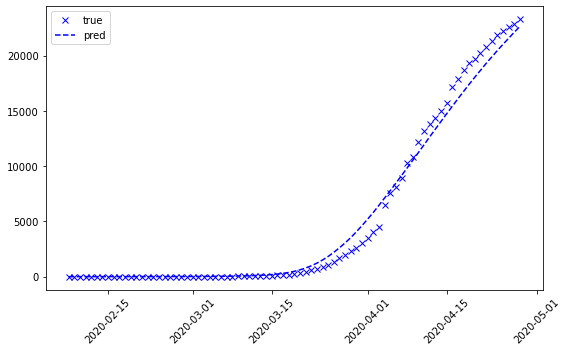

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.plot(times, np.cumsum(data), "bx", label="true")
plt.plot(times, np.cumsum(mu), "b--", label="pred")
# plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()

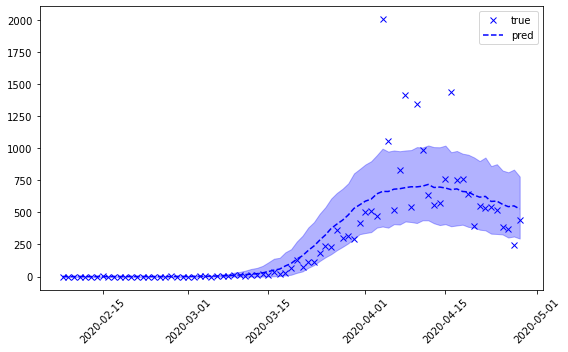

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.plot(times, data, "bx", label="true")
plt.plot(times, mu, "b--", label="pred")
plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()

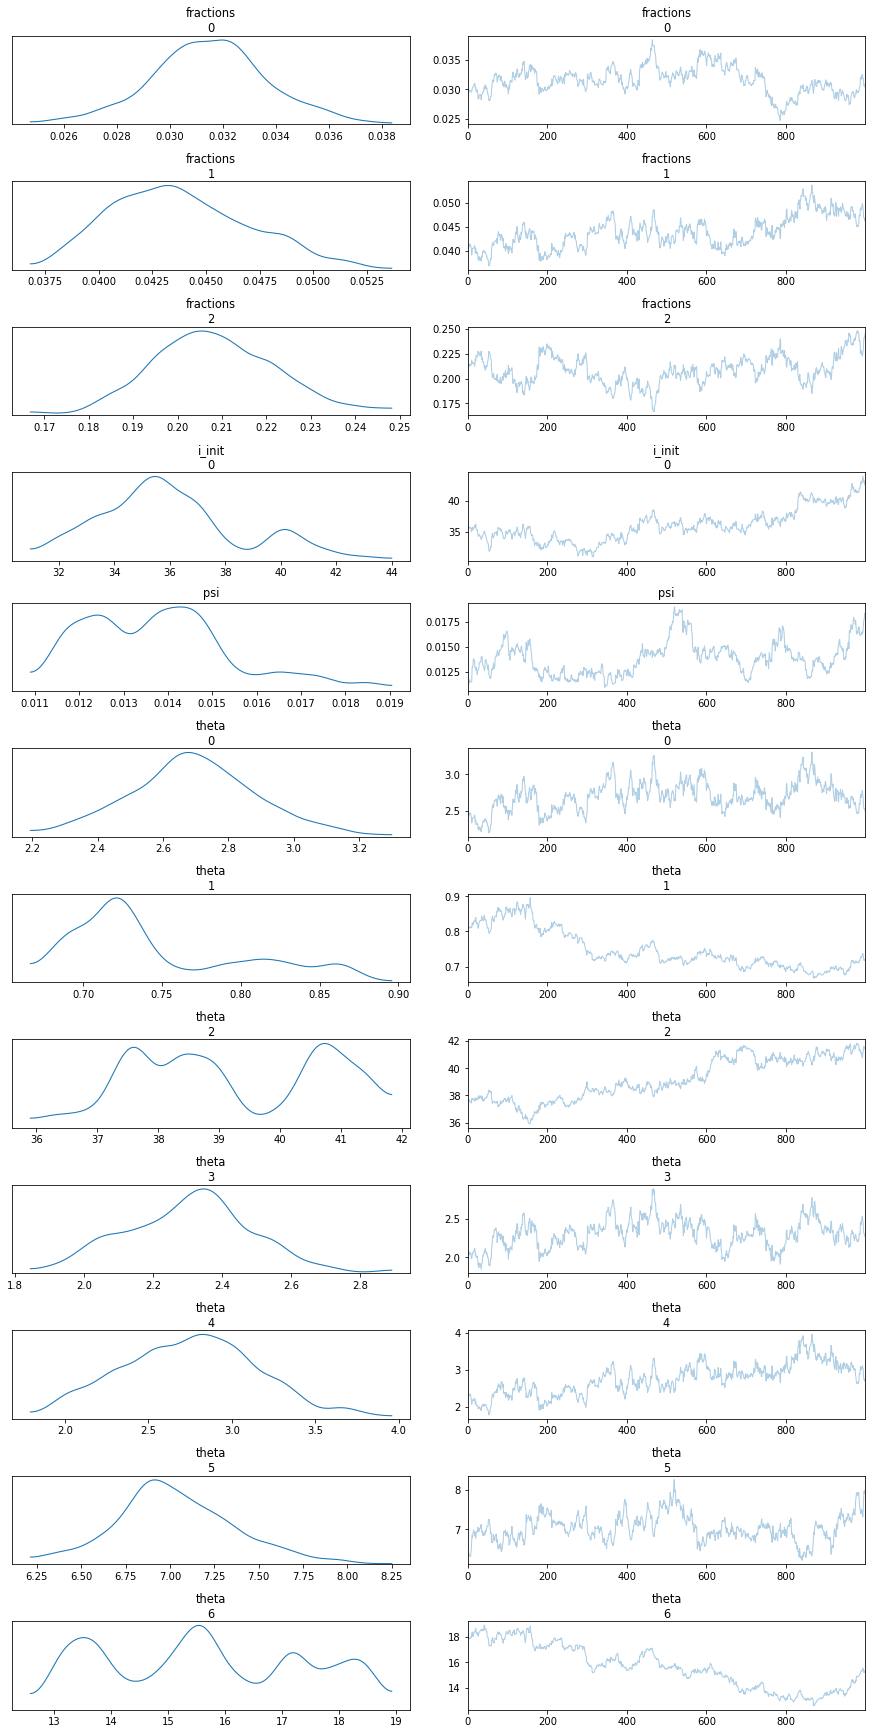

In [21]:
inference_data = az.from_numpyro(mcmc)

az.plot_trace(inference_data) ;

In [120]:
daily_deaths = np.array([0, 0, 1, 2, 3, 5]) + 1.

In [ ]:
with numpyro.handlers.seed(rng_seed=8):
#     psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))
    psi = 0.5
    gp_sample = numpyro.sample('y', dist.GammaPoisson(psi * daily_deaths, rate=psi))
    
gp_sample

# SI model
Inspired by the predator-prey tutorial and the PYMC3 ode blog post

We use first a SI model, of two populations:
- Susceptible (S)
- Infected (I)

The dynamics of populations is governed by a system of differential equations:
- $\frac{dS}{dt} = - R_0 S I$
- $\frac{dI}{dt} = R_0 S I$

In [3]:
def dz_dt(z, t, r0):
    s = np.clip(z[0], 0., 1.)
    i = np.clip(z[1], 0., 1.)
    ds_dt = - r0 * i * s
    di_dt = r0 * i * s
    return np.stack([ds_dt, di_dt])

si_int = build_odeint(dz_dt, rtol=1e-5, atol=1e-3, mxstep=500)

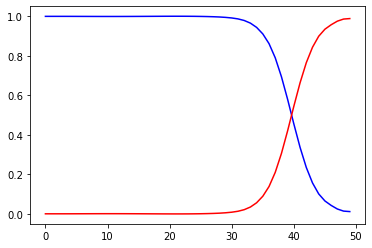

In [4]:
n_inf = 1e-7
res = si_int(np.array([1. - n_inf, n_inf]), np.arange(50.), 0.5)
plt.plot(res[:, 0], c='b')
plt.plot(res[:, 1], c='r')

In [5]:
def model(N, y=None):
    i_init = numpyro.sample('i_init', dist.LogNormal(loc=5, scale=1), sample_shape=(1,)) / pop_fr
    z_init = np.array([1. - i_init[0], i_init[0]])
    ts = np.arange(float(N))
    
    r0 = numpyro.sample('r0', dist.TruncatedNormal(low=0.1, loc=3.3, scale=1.0))
    
    z = si_int(z_init, ts, r0)
    
    sigma = numpyro.sample('sigma', dist.HalfCauchy(1.))
    
    numpyro.sample('y', dist.Normal(z, sigma), obs=y)

In [6]:
# use dense_mass for better mixing rate
mcmc = MCMC(NUTS(model, dense_mass=True),
            500, 500, num_chains=NUM_CHAINS,
            progress_bar=True)
mcmc.run(PRNGKey(0), N=data.shape[0], y=data / pop_fr)
mcmc.print_summary()

warmup:  21%|██        | 210/1000 [03:10<11:54,  1.11it/s, 1023 steps of size 1.13e-03. acc. prob=0.74] 


KeyboardInterrupt: 

In [ ]:
y_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])['y']

pop_pred = y_pred
mu, pi = np.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)
# mu = np.exp(mu)
# pi = np.exp(pi)

In [ ]:
# plt.plot(times, data[:, 0], "ko", mfc="none", ms=4, label="true hare", alpha=0.67)
# plt.plot(times, np.log(data[:, 1]), "bx", label="true infected")
# plt.plot(times, mu[:, 0], "k-.", label="pred sane", lw=1, alpha=0.67)
plt.plot(times, mu[:, 1], "b--", label="pred infected")
# plt.fill_between(times, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(times, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.gca().set(xlabel="date", ylabel="population")
# plt.title("Posterior predictive (80% CI) with predator-prey pattern.")
plt.legend()

plt.tight_layout()

In [ ]:
inference_data = az.from_numpyro(mcmc)
inference_data

In [ ]:
az.plot_trace(inference_data) ;